<a href="https://colab.research.google.com/github/Neurotech-BCI/ErrP/blob/main/Data_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 50.9 MB/s eta 0:00:00


In [1]:
from pathlib import Path
directory_path = Path('/content/drive/MyDrive/data/2 1 26')
data_files = [str(file_path.resolve()) for file_path in directory_path.rglob('*.edf')]
print(data_files)

['/content/drive/.shortcut-targets-by-id/1XEofwF7ZdG32v3kquOs876WE87MkfTlq/data/2 1 26/26_2_1_ben1_raw.edf', '/content/drive/.shortcut-targets-by-id/1XEofwF7ZdG32v3kquOs876WE87MkfTlq/data/2 1 26/26_2_1_ben2_raw.edf', '/content/drive/.shortcut-targets-by-id/1XEofwF7ZdG32v3kquOs876WE87MkfTlq/data/2 1 26/26_2_1_omer3_raw.edf', '/content/drive/.shortcut-targets-by-id/1XEofwF7ZdG32v3kquOs876WE87MkfTlq/data/2 1 26/26_2_1_omer4_raw.edf']


In [8]:
event_id = {
    'event_type_1': 1,
    'event_type_2': 2,
    'event_type_3': 3,
    'event_type_4': 4,
}

In [9]:
import mne
import numpy as np

def load_raw_edf(edf_file_path):
  data = mne.io.read_raw_edf(edf_file_path, preload = True)
  print(data.info)
  print(f"Original channel names: {data.info.ch_names}")

  ### Reference to Left Ear channel, default is Pz ###
  data.set_eeg_reference(ref_channels=['EEG LE-Pz'])

  ### Standardize channel names ###
  rename_dict = {}
  for ch_name in data.ch_names:
      if '-Pz' in ch_name:
          rename_dict[ch_name] = ch_name.replace('-Pz', '')
      if ch_name == "Pz":
          rename_dict[ch_name] = "EEG Pz"
  data.rename_channels(rename_dict)
  print(f"Updated channel names: {data.info.ch_names}")

  ### Preprocess with bandpass and notch filter ###
  data.filter(l_freq=1.0, h_freq=50.0)
  data.notch_filter(freqs=[60.0], picks="eeg", verbose=False)

  ### Find events labeled in the Trigger column ###
  events = mne.find_events(data, stim_channel='Trigger', min_duration=0.0)
  print(f'Found {len(events)} events')
  print(f'Event IDs: {set(events[:, 2])}')

  ### Create epochs time locked to the event triggers ###
  epochs = mne.Epochs(
      data,
      events,
      event_id=event_id,
      tmin=-0.2,      # Start 200 ms before event
      tmax=0.8,       # End 800 ms after event
      baseline=(-0.2, 0),  # Baseline period for correction
      preload=True
  )
  channels = ['EEG F4', 'EEG C4', 'EEG P4', 'EEG P3', 'EEG C3', 'EEG F3', 'EEG Pz']
  epochs = epochs.pick(channels)

  ### Plot epochs ###
  evokeds = [epochs[cond].average() for cond in list(event_id.keys())]
  mne.viz.plot_compare_evokeds(evokeds)

  ### Convert epochs and event labels to numpy ###
  samples = []
  labels = []
  for key in event_id.keys():
        datum = epochs[key].get_data()[:,:,:-1]
        samples.append(datum)
        labels.extend([key]*datum.shape[0])
  X = np.concatenate(samples, axis=0)
  y = np.array(labels)

  return X, y



Extracting EDF parameters from /content/drive/.shortcut-targets-by-id/1XEofwF7ZdG32v3kquOs876WE87MkfTlq/data/2 1 26/26_2_1_ben1_raw.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 124199  =      0.000 ...   413.997 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: EEG LE-Pz, EEG F4-Pz, EEG C4-Pz, EEG P4-Pz, EEG P3-Pz, EEG ...
 chs: 12 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 150.0 Hz
 meas_date: 2026-02-01 14:34:58 UTC
 nchan: 13
 projs: []
 sfreq: 300.0 Hz
 subject_info: <subject_info | his_id: X, sex: 1, last_name: X, birthday: 2000-01-01>
>
Original channel names: ['EEG LE-Pz', 'EEG F4-Pz', 'EEG C4-Pz', 'EEG P4-Pz', 'EEG P3-Pz', 'EEG C3-Pz', 'EEG F3-Pz', 'Pz', 'Trigger', 'Event', 'Ax', 'Ay', 'Az']
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Updated channel names: ['EEG LE', 'EEG F4', 'EEG C4', 'EEG P4', 'EEG P3', 'EEG C3', 'EEG F3', 'EEG Pz', 'Trigger', 'Event', 'Ax', 'Ay

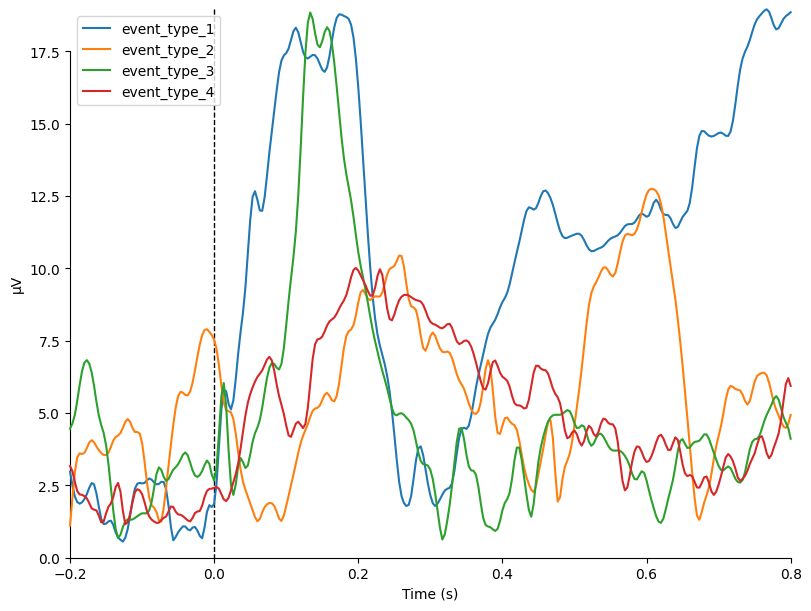

Shape of EEG data (num_trials, num_channels, epoch_len): (100, 7, 300)
Shape of labels array (num_trials,): (100,)
Dataset label counts:
[['event_type_1' '27']
 ['event_type_2' '23']
 ['event_type_3' '40']
 ['event_type_4' '10']]


In [11]:
data_file = data_files[0]
X, y = load_raw_edf(data_file)
print(f"Shape of EEG data (num_trials, num_channels, epoch_len): {X.shape}")
print(f"Shape of labels array (num_trials,): {y.shape}")
unique_labels, counts = np.unique(y,return_counts=True)
print("Dataset label counts:")
print(np.asarray((unique_labels, counts)).T)